# MPB 3D waveguide modeling

initial testing

In [1]:
# preamble

from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import meep as mp
import meep.materials as mats
from meep import mpb
import meep.adjoint as mpa
# import meeputils as mu
from wurlitzer import pipes, STDOUT
from io import StringIO
# from pint import UnitRegistry
# u = UnitRegistry()

from scipy.interpolate import RectBivariateSpline
# my additions
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.optimize as opt
import warnings
import h5py
import sys
from mpb_adj import OptimizationProblem


# material fns
### import index models ###
home = str( Path.home() )
nlo_dir = home+'/github/optics_modeling/nlo'
if nlo_dir not in sys.path:
    sys.path.append(nlo_dir)
import NLO_tools as nlo

u = nlo.u

def _n_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_MgO_LN(λ*u.um,T,axis=axis)[0,0]

def _ng_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_g_MgO_LN(λ*u.um,T,axis=axis)

def _n_si3n4(λ,T=300*u.degK):
    return nlo.n_Si3N4(λ*u.um,T)[0,0]

def _ng_si3n4(λ,T=300*u.degK):
    return nlo.n_g_Si3N4(λ*u.um,T)

def _n_sio2(λ,T=300*u.degK):
    return nlo.n_SiO2(λ*u.um,T)[0,0]

def _ng_sio2(λ,T=300*u.degK):
    return nlo.n_g_SiO2(λ*u.um,T)

def _n_mgf2(λ,T=300*u.degK):
    return nlo.n_MgF2(λ*u.um,T)

def _ng_mgf2(λ,T=300*u.degK):
    return nlo.n_g_MgF2(λ*u.um,T)

# n_Si3N4(lm_in,T_in)

### Cauchy Equation fit coefficients for Gavin's ALD alumina films ###
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4
A_alumina = 1.602
B_alumina = 0.01193
C_alumina = -0.00036


### Cauchy Equation fit coefficients for 100nm Hafnia (HfO2) films ###
## taken from
## Khoshman and Kordesch. "Optical properties of a-HfO2 thin films." Surface and Coatings Technology 201.6 (2006)
## great fit to measured data from sputtered amorphous Hafnia, haven't found one for ALD Hafnia specifically
## they also report loss, with a sharp absorption edge near 5.68 ± 0.09 eV (~218 nm)
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4

# # fit for spectroscopic ellipsometer measurement for a 250nm thick film, good 300-1400nm
# A_hafnia = 1.85
# B_hafnia = 1.17e-8
# C_hafnia = 0.0

# fit for spectroscopic ellipsometer measurement for a 112nm thick film, good 300-1400nm
A_hafnia = 1.86
B_hafnia = 7.16e-9
C_hafnia = 0.0

# In_{1-x} Ga_x As_y P_{1-y}
# Modified single-oscillator model
# F. Fiedler and A. Schlachetzki. Optical parameters of InP-based waveguides.
#   Solid-State Electronics, 30(1):73–83, 1987.
def _n_ingaasp(y, lam_mu):
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    Eph = 1.24 / lam_mu
    return np.sqrt(np.abs(1 + Ed / E0 + Ed * Eph ** 2 / E0 ** 3 + Ed * Eph ** 4 / (2 * E0 ** 3 * (E0 ** 2 - Eg ** 2)) *
                          np.log((2 * E0 ** 2 - Eg ** 2 - Eph ** 2) / (Eg ** 2 - Eph ** 2))))


# Just take the derivative: n_g = n + (omega/2n) d(n^2)/d(omega)
def _ng_ingaasp(y, lam_mu):
    n = _n_ingaasp(y, lam_mu);
    hw = 1.24 / lam_mu;
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    return (n + 1 / (2 * n) * ((2 * Ed * hw ** 2) / E0 ** 3 + (2 * Ed * (hw ** 4)) / E0 ** 3 * (
                hw ** 2 / ((2 * E0 ** 2 - Eg ** 2 - hw ** 2) * (Eg ** 2 - hw ** 2)) +
                1 / (E0 ** 2 - Eg ** 2) * np.log((2 * E0 ** 2 - Eg ** 2 - hw ** 2) / (Eg ** 2 - hw ** 2)))))


# Lambda is in microns here.
def get_index(mat, lam):
    lam = lam
    if (mat == 'Si3N4'):
        # 1) H. R. Philipp. Optical properties of silicon nitride,
        #    J. Electrochim. Soc. 120, 295-300 (1973)
        # 2) T. Baak. Silicon oxynitride; a material for GRIN optics,
        #    Appl. Optics 21, 1069-1072 (1982)
        # return np.sqrt(1 + (2.8939 * lam ** 2) / (lam ** 2 - 0.1396 ** 2))
        return _n_si3n4(lam)
    elif (mat == 'SiO2'):
        # I. H. Malitson. Interspecimen Comparison of the Refractive Index of Fused Silica,
        # J. Opt. Soc. Am. 55, 1205-1208 (1965)
        # return np.sqrt(
        #     np.maximum(1 + (0.6961 * lam ** 2) / (lam ** 2 - 0.06840 ** 2) + (0.4079 * lam ** 2) / (lam ** 2 - 0.1162 ** 2)
        #     + (0.8974 * lam ** 2) / (lam ** 2 - 9.8961 ** 2), 1))
        return _n_sio2(lam)
    elif (mat == 'MgF2'):
        return _n_mgf2(lam)
    elif (mat == 'Si'):
        # 1) C. D. Salzberg and J. J. Villa. Infrared Refractive Indexes of Silicon,
        #    Germanium and Modified Selenium Glass, J. Opt. Soc. Am., 47, 244-246 (1957)
        # 2) B. Tatian. Fitting refractive-index data with the Sellmeier dispersion formula,
        #    Appl. Opt. 23, 4477-4485 (1984)
        return np.sqrt(
            1 + (10.6684 * lam ** 2) / (lam ** 2 - 0.3015 ** 2) + (0.003043 * lam ** 2) / (lam ** 2 - 1.1347 ** 2)
            + (1.5413 * lam ** 2) / (lam ** 2 - 1104 ** 2))
    elif (mat == 'Alumina'):
        return A_alumina + B_alumina / lam**2 + C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina
    elif (mat == 'Hafnia'):
        return A_hafnia + B_hafnia / lam**2 + C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'InP'):
        return _n_ingaasp(0, lam)
    elif (mat == 'LiNbO3'):
        return _n_linbo3(lam)
    elif (type(mat) == str and mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _n_ingaasp(y, lam)
    elif (type(mat) in [int, float, np.float64]):
        return mat
    else:
        raise ValueError("Material " + mat + " not supported.")


def get_ng(mat, lam):
    if (mat == 'InP'):
        return _ng_ingaasp(0, lam * 1e6)
    elif (mat == 'Si3N4'):
        return _ng_si3n4(lam)
    elif (mat == 'SiO2'):
        return _ng_sio2(lam)
    elif (mat == 'MgF2'):
        return _ng_mgf2(lam)
    elif (mat == 'LiNbO3'):
        return _ng_linbo3(lam)
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'Alumina'):
        return A_alumina + 3 * B_alumina / lam**2 + 5 * C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina, analytic derivative for ng
    elif (mat == 'Hafnia'):
        return A_hafnia + 3 * B_hafnia / lam**2 + 5* C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _ng_ingaasp(y, lam * 1e6)
    else:
        # A lazy hack...
        [n100, n101, n099] = [get_index(mat, lam / x) for x in [1.00, 1.01, 0.99]]
        w0 = 2 * np.pi * 3e8 / lam
        dndw = (n101 - n099) / (0.02 * w0)
        return (dndw * w0 + n100)

In [62]:
# geometry and solver parameters

# define new parameters for angled sidewalls, partial etch, conformal deposited layers after wg etch,

θ = 0. # sidewall angle in degrees, 0 = vertical
w_top = 0.5*u.um #0.2*u.um # top width of partially etched "core layer" in microns
t_core = 0.5*u.um # full thickness of "core layer" in microns
t_etch = 0.4*u.um #0.15 # etch depth into "core layer" in microns
r_hole = 0.1*u.um

lam = 0.85*u.um # free space wavelength in microns
dx_base = np.tan(np.deg2rad(θ)) * t_etch
nk = 20
mat_core = 'Alumina'
mat_clad = 'SiO2'
Xgrid = 4
Ygrid = 4
Zgrid = 1
n_modes = 16
res_x = 32
res_y = 32
res_z = 32
res = mp.Vector3(res_x,res_y,res_z)
do_func = None

# manually convert to unitless quantities for now
w_top = w_top.to(u.um).m
t_core = t_core.to(u.um).m
t_etch = t_etch.to(u.um).m
r_hole = r_hole.to(u.um).m
lam = lam.to(u.um).m
#ω = 1/lam # frequency in units of c

band_funcs = [mpb.fix_efield_phase,]
#                        mpb.output_efield,
#                            mpb.output_hfield,
#                            mpb.output_dpwr,
#                            mpb.output_poynting,
#                            mpb.output_tot_pwr,
                       #mpb.output_dpwr_in_objects,]


# holes = [mp.Cylinder(center=mp.Vector3(0,0,0.25),
#                      height=mp.inf,
#                      radius=r_hole,
#                      axis=mp.Vector3(0,1,0),
#                      material=med_clad,
#                     ),
#          mp.Cylinder(center=mp.Vector3(0,0,-0.25),
#                      height=mp.inf,
#                      radius=r_hole,
#                      axis=mp.Vector3(0,1,0),
#                      material=med_clad,
#                     ),
#          mp.Cylinder(center=mp.Vector3(0,0,0),
#                      height=mp.inf,
#                      radius=1.5*r_hole,
#                      axis=mp.Vector3(0,1,0),
#                      material=med_clad,
#                     ),
#         ]

# holes = [
#          mp.Cylinder(center=mp.Vector3(0,0,0),
#                      height=mp.inf,
#                      radius=r_hole,
#                      axis=mp.Vector3(0,1,0),
#                      material=med_clad,
#                     ),
#         ]

holes = [mp.Cylinder(center=mp.Vector3(0.4,0,0),
                     height=mp.inf,
                     radius=r_hole,
                     axis=mp.Vector3(0,1,0),
                     material=med_clad,
                    ),
         mp.Cylinder(center=mp.Vector3(-0.4,0,0),
                     height=mp.inf,
                     radius=r_hole,
                     axis=mp.Vector3(0,1,0),
                     material=med_clad,
                    ),
        ]

# get phase and group indices for these materials at this wavelength
n_core =  get_index(mat_core, lam); ng_core =  get_ng(mat_core, lam)
n_clad =  get_index(mat_clad, lam); ng_clad = get_ng(mat_clad, lam)
med_core = mp.Medium(index=n_core); med_clad = mp.Medium(index=n_clad)

In [64]:
# initialize solver

# compute a few more useful quantities with user parameters
nx = Xgrid * res_x
ny = Ygrid * res_y
nz = Zgrid * res_z

x = Xgrid * np.linspace(-1/2., 1/2., nx)
y = Ygrid * np.linspace(-1/2., 1/2., ny)
z = Zgrid * np.linspace(-1/2., 1/2., nz)

# k_points = [mp.Vector3(0, 0, 2.8),]
k_points = [mp.Vector3(), mp.Vector3(0, 0, 0.5)]
k_points = mp.interpolate(nk, k_points)
kz = np.array([np.array(kk)[2] for kk in k_points])

# define geometry with design region
lat = mp.Lattice(size=mp.Vector3(Xgrid, Ygrid, Zgrid))
dx_base = np.tan(np.deg2rad(θ)) * t_etch

verts_core = [mp.Vector3(-w_top/2.,t_etch/2),
        mp.Vector3(w_top/2.,t_etch/2),
        mp.Vector3(w_top/2+dx_base,-t_etch/2),
        mp.Vector3(-w_top/2-dx_base,-t_etch/2),
       ]
core = mp.Prism(verts_core, height=mp.inf, material=med_core)



if t_etch<t_core:   # partial etch
    slab = mp.Block(size=mp.Vector3(mp.inf,
                                    t_core-t_etch,
                                    mp.inf,),
                    center=mp.Vector3(0,
                                      -t_core/2,
                                      0,),
                    material=med_core)
    geom = [core,slab,] + holes
else:
    geom = [core,] + holes


# instantiate ModeSolver and solve for a few modes

blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_modes,
                        default_material=med_clad)
    ms.geometry = geom
    ms.default_material = med_clad
    ms.init_params(mp.NO_PARITY, False)
    ms.run(*band_funcs)


ω = np.array(ms.all_freqs)
neff = kz[:,np.newaxis] / ω


Working in 3 dimensions.
Grid size is 128 x 128 x 32.
Solving for 8 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (4, 0, 0)
     (0, 4, 0)
     (0, 0, 1)
Cell volume = 16
Reciprocal lattice vectors (/ 2 pi):
     (0.25, -0, 0)
     (-0, 0.25, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.25,0.2,0)
          (0.25,0.2,0)
          (0.25,-0.2,0)
          (-0.25,-0.2,0)
     block, center = (0,-0.25,0)
          size (1e+20,0.1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.4,0,0)
          radius 0.1, height 1e+20, axis (0, 1, 0)
     cylinder, center = (-0.4,0,0)
          radius 0.1, height 1e+20, axis (0, 1, 0)
Geometric object tree has depth 2 and 26 object nodes (vs. 4 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random number

    iteration    4: trace = 0.4129092674308913 (0.000533209% change)
    iteration    5: trace = 0.4129091171670999 (3.63915e-05% change)
    iteration    6: trace = 0.4129090988440828 (4.43754e-06% change)
Finished solving for bands 9 to 16 after 6 iterations.
Finished k-point with 6 mean iterations/band.
freqs:, 2, 0, 0, 0.0238095, 0.0238095, 0.0163214, 0.0163306, 0.171137, 0.171476, 0.172019, 0.172154, 0.172342, 0.172445, 0.172826, 0.172836, 0.241323, 0.242429, 0.242684, 0.242735, 0.243213, 0.243292
elapsed time for k point: 27.90411686897278
Fixing e-field (band 1) phase by 0.999988 + 0.00480143i; max ampl. = 0.186453
Fixing e-field (band 2) phase by -1 + 6.01543e-11i; max ampl. = 0.184083
Fixing e-field (band 3) phase by 0.00304509 + -0.999995i; max ampl. = 0.34283
Fixing e-field (band 4) phase by 0.655004 + 0.755625i; max ampl. = 0.262877
Fixing e-field (band 5) phase by -1 + 0.00031397i; max ampl. = 0.264514
Fixing e-field (band 6) phase by 0.000117539 + 1i; max ampl. = 0.341335

Fixing e-field (band 7) phase by -0.0424087 + 0.9991i; max ampl. = 0.282491
Fixing e-field (band 8) phase by -1 + -6.54493e-07i; max ampl. = 0.248988
Fixing e-field (band 9) phase by 1 + 7.15608e-07i; max ampl. = 0.222129
Fixing e-field (band 10) phase by 0.243479 + -0.969906i; max ampl. = 0.258007
Fixing e-field (band 11) phase by -0.999999 + 0.00156605i; max ampl. = 0.309739
Fixing e-field (band 12) phase by 0.584872 + 0.811126i; max ampl. = 0.238945
Fixing e-field (band 13) phase by -5.33734e-05 + -1i; max ampl. = 0.268695
Fixing e-field (band 14) phase by -0.38349 + -0.923545i; max ampl. = 0.250165
Fixing e-field (band 15) phase by -0.000267629 + -1i; max ampl. = 0.255588
Fixing e-field (band 16) phase by -0.554843 + -0.831955i; max ampl. = 0.264878
solve_kpoint (0,0,0.190476):
Solving for bands 1 to 8...
    iteration    1: trace = 0.312090138508328 (0.000688426% change)
    iteration    2: trace = 0.3120899288901723 (6.71659e-05% change)
    iteration    3: trace = 0.312089864224

Fixing e-field (band 11) phase by -0.0021846 + 0.999998i; max ampl. = 0.277578
Fixing e-field (band 12) phase by 0.999571 + 0.0292953i; max ampl. = 0.267841
Fixing e-field (band 13) phase by 1 + -0.000183559i; max ampl. = 0.284105
Fixing e-field (band 14) phase by 0.929673 + -0.368385i; max ampl. = 0.276313
Fixing e-field (band 15) phase by 1 + 0.000177744i; max ampl. = 0.267322
Fixing e-field (band 16) phase by 0.910708 + -0.41305i; max ampl. = 0.272035
solve_kpoint (0,0,0.261905):
Solving for bands 1 to 8...
    iteration    1: trace = 0.4334549479618762 (0.000670562% change)
    iteration    2: trace = 0.4334545652240542 (8.82994e-05% change)
    iteration    3: trace = 0.433454485435684 (1.84076e-05% change)
    iteration    4: trace = 0.4334544123890873 (1.68522e-05% change)
    iteration    5: trace = 0.4334537894464149 (0.000143716% change)
    iteration    6: trace = 0.433453438093808 (8.10589e-05% change)
    iteration    7: trace = 0.4334534049119402 (7.65523e-06% change)
Fin

    iteration    4: trace = 0.5930902915933948 (2.75679e-05% change)
    iteration    5: trace = 0.5930889998528326 (0.000217799% change)
    iteration    6: trace = 0.5930865088599736 (0.000420004% change)
    iteration    7: trace = 0.5930860269248939 (8.12588e-05% change)
    iteration    8: trace = 0.5930858432360536 (3.09717e-05% change)
    iteration    9: trace = 0.5930853712529081 (7.95809e-05% change)
    iteration   10: trace = 0.5930798389985134 (0.000932797% change)
    iteration   11: trace = 0.5930597584890531 (0.00338586% change)
    iteration   12: trace = 0.5930472201241739 (0.0021142% change)
    iteration   13: trace = 0.5930361521681888 (0.0018663% change)
    iteration   14: trace = 0.5930326132288043 (0.000596751% change)
    iteration   15: trace = 0.5930321159904606 (8.38467e-05% change)
    iteration   16: trace = 0.5930318037582121 (5.26502e-05% change)
    iteration   17: trace = 0.5930311512786272 (0.000110024% change)
    iteration   18: trace = 0.593030390

Fixing e-field (band 13) phase by 1 + -6.68424e-05i; max ampl. = 0.28426
Fixing e-field (band 14) phase by -0.999902 + 0.0139988i; max ampl. = 0.303819
Fixing e-field (band 15) phase by -1 + -1.26981e-05i; max ampl. = 0.292319
Fixing e-field (band 16) phase by 0.995727 + -0.0923411i; max ampl. = 0.295721
solve_kpoint (0,0,0.404762):
Solving for bands 1 to 8...
    iteration    1: trace = 0.7907644779481509 (0.000623186% change)
    iteration    2: trace = 0.7907634074045531 (0.000135381% change)
    iteration    3: trace = 0.7907631037628953 (3.83986e-05% change)
    iteration    4: trace = 0.7907630403821951 (8.01513e-06% change)
Finished solving for bands 1 to 8 after 4 iterations.
Solving for bands 9 to 16...
    iteration    1: trace = 1.026587248863824 (0.000275056% change)
    iteration    2: trace = 1.026586804017227 (4.33326e-05% change)
    iteration    3: trace = 1.026586668673533 (1.31839e-05% change)
    iteration    4: trace = 1.026586254911959 (4.03046e-05% change)
    it

    iteration   38: trace = 1.174644648162813 (0.000475874% change)
    iteration   39: trace = 1.174638988359262 (0.000481832% change)
    iteration   40: trace = 1.17463325624954 (0.00048799% change)
    iteration   41: trace = 1.174627449442416 (0.000494352% change)
    iteration   42: trace = 1.174621565526129 (0.000500919% change)
    iteration   43: trace = 1.174615602092782 (0.000507691% change)
    iteration   44: trace = 1.174609556766994 (0.000514666% change)
    iteration   45: trace = 1.174603427239611 (0.000521837% change)
    iteration   46: trace = 1.174597211306937 (0.000529196% change)
    iteration   47: trace = 1.174590906916142 (0.000536729% change)
    iteration   48: trace = 1.174584512217314 (0.000544421% change)
    iteration   49: trace = 1.174578025622421 (0.000552247% change)
    iteration   50: trace = 1.174571445871574 (0.000560182% change)
    iteration   51: trace = 1.174564772106109 (0.000568189% change)
    iteration   52: trace = 1.174558003948135 (0.0

    iteration   28: trace = 1.025647849225995 (0.000415766% change)
    iteration   29: trace = 1.025643563313125 (0.000417875% change)
    iteration   30: trace = 1.025639254683936 (0.000420091% change)
    iteration   31: trace = 1.025634922309888 (0.000422408% change)
    iteration   32: trace = 1.025630565259908 (0.000424816% change)
    iteration   33: trace = 1.025626182720412 (0.000427303% change)
    iteration   34: trace = 1.025621774016191 (0.000429856% change)
    iteration   35: trace = 1.025617338632151 (0.000432459% change)
    iteration   36: trace = 1.025612876235732 (0.000435095% change)
    iteration   37: trace = 1.025608386699989 (0.000437743% change)
    iteration   38: trace = 1.025603870126884 (0.000440381% change)
    iteration   39: trace = 1.025599326870503 (0.000442985% change)
    iteration   40: trace = 1.025594757559535 (0.000445527% change)
    iteration   41: trace = 1.025590163118401 (0.000447979% change)
    iteration   42: trace = 1.025585544786208 (0

Finished solving for bands 1 to 8 after 149 iterations.
Solving for bands 9 to 16...
    iteration    1: trace = 1.24990789025775 (2.06268% change)
    iteration    2: trace = 1.245388667632624 (0.362219% change)
    iteration    3: trace = 1.244028107760138 (0.109308% change)
    iteration    4: trace = 1.23999674344127 (0.324583% change)
    iteration    5: trace = 1.230075469167384 (0.803319% change)
    iteration    6: trace = 1.206734675577529 (1.91568% change)
    iteration    7: trace = 1.201566391058666 (0.429206% change)
    iteration    8: trace = 1.198542437515972 (0.251985% change)
    iteration    9: trace = 1.195979932783485 (0.214031% change)
    iteration   10: trace = 1.193401218678971 (0.215848% change)
    iteration   11: trace = 1.189114546377373 (0.359844% change)
    iteration   12: trace = 1.187496496897904 (0.136164% change)
    iteration   13: trace = 1.186754699708361 (0.0624868% change)
    iteration   14: trace = 1.186226423779706 (0.0445242% change)
    ite

    iteration   18: trace = 1.053935705754927 (0.00950002% change)
    iteration   19: trace = 1.053834355306163 (0.00961684% change)
    iteration   20: trace = 1.053766435147566 (0.00644526% change)
    iteration   21: trace = 1.053703548518513 (0.00596797% change)
    iteration   22: trace = 1.053642283307767 (0.00581444% change)
    iteration   23: trace = 1.053595537773251 (0.00443666% change)
    iteration   24: trace = 1.053566850963052 (0.00272279% change)
    iteration   25: trace = 1.053549248721247 (0.00167074% change)
    iteration   26: trace = 1.053537050382773 (0.00115784% change)
    iteration   27: trace = 1.053526909163939 (0.000962592% change)
    iteration   28: trace = 1.053516810932337 (0.000958521% change)
    iteration   29: trace = 1.053505486277813 (0.00107494% change)
    iteration   30: trace = 1.053492362616661 (0.00124572% change)
    iteration   31: trace = 1.053477740468891 (0.00138798% change)
    iteration   32: trace = 1.053462679313122 (0.00142967% c

    iteration   50: trace = 1.176247321730747 (0.00393612% change)
    iteration   51: trace = 1.176238718513346 (0.000731415% change)
    iteration   52: trace = 1.176235224031 (0.00029709% change)
    iteration   53: trace = 1.176229324805724 (0.000501536% change)
    iteration   54: trace = 1.176221746430115 (0.000644296% change)
    iteration   55: trace = 1.176206425703548 (0.00130255% change)
    iteration   56: trace = 1.176189847135472 (0.0014095% change)
    iteration   57: trace = 1.176187313841077 (0.000215382% change)
    iteration   58: trace = 1.176186306473227 (8.56469e-05% change)
    iteration   59: trace = 1.17618390592697 (0.000204096% change)
    iteration   60: trace = 1.176180297689528 (0.000306775% change)
    iteration   61: trace = 1.176176340557384 (0.00033644% change)
    iteration   62: trace = 1.176173453909534 (0.000245427% change)
    iteration   63: trace = 1.176172458616569 (8.46213e-05% change)
    iteration   64: trace = 1.176172256945688 (1.71464e-05

/home/dodd/miniconda3/envs/mp_dev/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


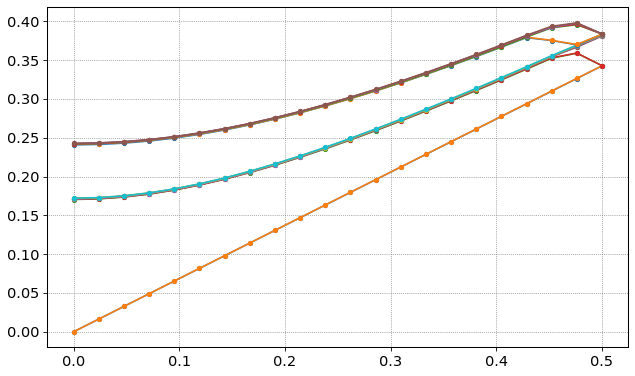

In [65]:
# visualize dispersion

plt.plot(kz,ω,'.-')

In [66]:
# ms.solve_kpoint(mp.Vector3(0,0,0.25))
# E = np.stack([np.array(ms.get_efield(mind+1, bloch_phase=True)) for mind in range(n_modes)],axis=-1)
E = np.stack([np.array(ms.get_efield(mind+1, bloch_phase=False)) for mind in range(n_modes)],axis=-1)

epsilon: 2.10987-2.61735, mean 2.12868, harm. mean 2.12531, 100% > 1, 3.70701% "fill"


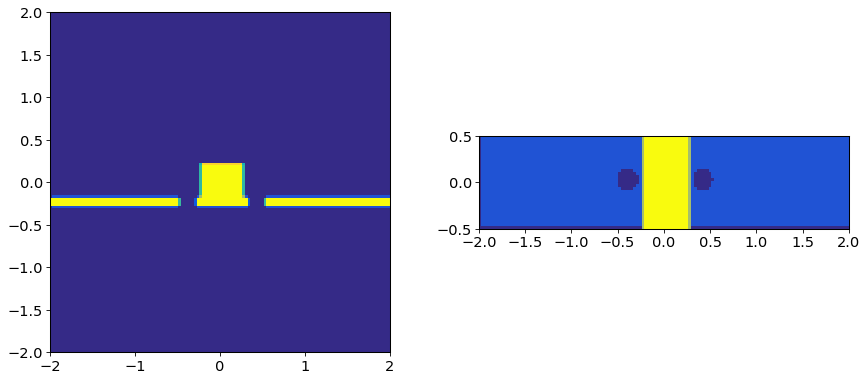

In [67]:
# visualize ε(x,y,z) and mode fields
ε = ms.get_epsilon()
figsize= 14, 6
xlim = -2,2
ylim = -2,2
zlim = -1,1

fig, ax = plt.subplots(1,2,figsize=(figsize))

yind = int(ny/2) - 6
zind = int(nz/2) 

ax[0].pcolormesh(x,y,ε[:,:,zind].T)
ax[1].pcolormesh(x,z,ε[:,yind,:].T)

for aa in ax.flatten():
    aa.set_aspect('equal')

In [68]:
# plot settings

zind = 10
F = 'E'
xlim = -2,2
ylim = -0.5,1.5
figsize=(14,5 + 3*n_modes)

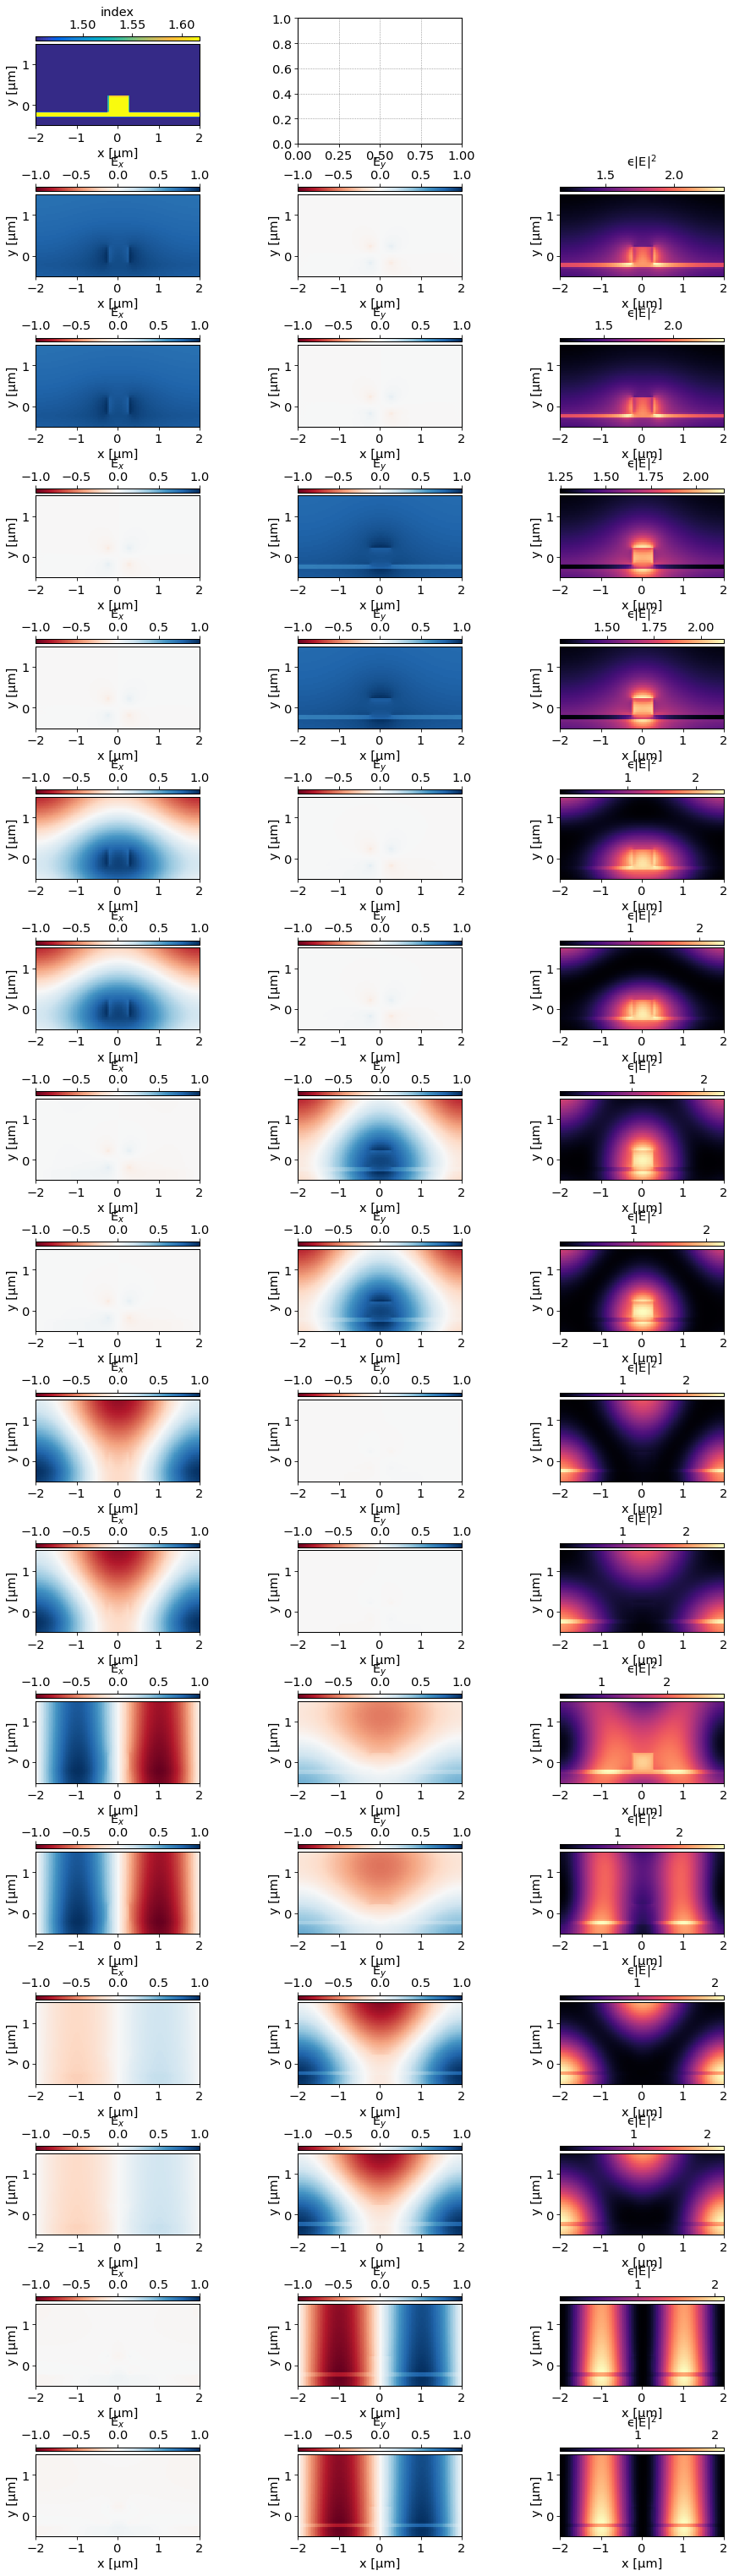

In [69]:
#### plot various computed fields for this instance ###
fig = plt.figure(figsize=figsize)
gs = GridSpec(n_modes+1,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
#ax02 = fig.add_subplot(gs[0,2])



# # # prepare spatial coordinate vectors
# nx = eps.shape[0]
# ny = eps.shape[1]
# x = Xgrid * np.linspace(-1/2., 1/2., nx)
# y = Ygrid * np.linspace(-1/2., 1/2., ny)

# plot index as a function of space
p00 = ax00.pcolormesh(x,y,np.sqrt(ε[:,:,zind].T),label='index')

# plot binary variable detecting core material
# p01 = ax01.pcolormesh(x,y,mat_core_mask.T,cmap=cm.Greys,label='core_mat')

# ax = [ax00,ax01,]
# p = [p00,p01,]
ax = [ax00,]
p = [p00,]

labels = ['index',
          'core_mat',
          'ϵ|E$_x$|$^2$',
          'E$_{x}$',
          'E$_{y}$',
          'E$_{z}$',
          'H$_{x}$',
          'H$_{y}$',
          'H$_{z}$',
         ]


for aind,a in enumerate(ax):
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')
    a.set_xlabel('x [μm]')
    a.set_ylabel('y [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(p[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

####################################################################


for mind in range(n_modes):
    ax =  [fig.add_subplot(gs[1+mind,0]),
            fig.add_subplot(gs[1+mind,1]),
            fig.add_subplot(gs[1+mind,2]),
          ]
    
    
#     F_norm = E[...,zind,:,mind] / E[...,zind,:,mind].flatten()[np.argmax(np.abs(E[...,zind,:,mind]))]
    F_norm = E[:,:,zind,:,mind] / E[:,:,zind,:,mind].flatten()[np.argmax(np.abs(E[:,:,zind,:,mind]))]
    eps_ei2 = ε[:,:,zind] * ( np.abs(F_norm[:,:,0])**2 + np.abs(F_norm[:,:,1])**2 + np.abs(F_norm[:,:,2])**2 )
    labels = [
              'E$_{x}$',
              'E$_{y}$',
#               'E$_{z}$',
              'ϵ|E|$^2$',
    ]

#     if F == "H":
#         F_norm = H[...,zind,:,mind] / H[...,zind,:,mind].flatten()[np.argmax(np.abs(H[...,zind,:,mind]))]
#         labels = [
#                   'H$_{x}$',
#                   'H$_{y}$',
#     #               'H$_{z}$',
#                    'ϵ|E|$^2$',
#                  ]
    
    # plot Fx, Fy, Fz and ϵ|E|^2 
    vmax = np.abs(F_norm.real).max()
    vmin = -1 * np.abs(F_norm.real).max() #E_norm.real.min()

    


    axind = 0 
    p10 = ax[axind].pcolormesh(x,
                          y,
                          F_norm[:,:,axind].T.real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

    axind = 1 
    p11 = ax[axind].pcolormesh(x,
                          y,
                          F_norm[:,:,axind].T.real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )

#     axind = 2
#     p12 = ax[axind].pcolormesh(x,
#                           y,
#                           F_norm[:,:,axind].T.real,
#                           cmap=cm.RdBu,
#                           vmin=vmin,
#                           vmax=vmax,
#                          )
    
    axind = 2
    p12 = ax[axind].pcolormesh(x,y,eps_ei2.T,cmap=cm.magma)







    ## format and label plots

#     ax = [ax10,ax11,ax12,ax13,ax20,ax21,ax22]
    p = [p10,p11,p12]
    




    for aind,a in enumerate(ax):
        if xlim:
            a.set_xlim(xlim)
        if ylim:
            a.set_ylim(ylim)
        a.set_aspect('equal')
        a.set_xlabel('x [μm]')
        a.set_ylabel('y [μm]')
        divider = make_axes_locatable(a)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cb = plt.colorbar(p[aind],
                     cax=cax,
                     orientation="horizontal",
                    )
        cb.set_label(labels[aind])#,labelpad=-1)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

# print field energy integrals
res = ms.compute_field_energy()

# create structure as MEEP sim to visualize

In [63]:
sim = mp.Simulation(resolution=50,
                    cell_size=mp.Vector3(Xgrid,Ygrid,Zgrid),
                    geometry=geom)

sim.init_sim()

eps_data = sim.get_epsilon()

-----------
Initializing structure...
time for choose_chunkdivision = 6.91414e-06 s
Working in 3D dimensions.
Computational cell is 2 x 2 x 1 with resolution 50
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.4,0.15,0)
          (0.4,0.15,0)
          (0.4,-0.15,0)
          (-0.4,-0.15,0)
          dielectric constant epsilon diagonal = (2.61735,2.61735,2.61735)
     block, center = (0,-0.1,0)
          size (1e+20,0.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.61735,2.61735,2.61735)
     cylinder, center = (0,0,0)
          radius 0.1, height 1e+20, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2.10987,2.10987,2.10987)
time for set_epsilon = 2.07627 s
-----------


In [ ]:
sim.plot3D()